In [ ]:
# PyTorch modules
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# General libraries
import sys
import os
import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection as sk_ModelSelection
import numpy as np
import math
import random
import copy
import pickle
from PIL import Image
sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'jpg'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!git clone https://github.com/guol1nag/temp.git

fatal: destination path 'temp' already exists and is not an empty directory.


# load data

In [ ]:
path = r'./temp'
file_path = []
for dirname, _, filenames in os.walk(path):
  for filename in filenames:
    if filename[-3:] == 'png':
      file_path.append(os.path.join(dirname, filename))
file_path = sorted(file_path)
print(file_path)

['./temp/gt.png', './temp/rgb.png']


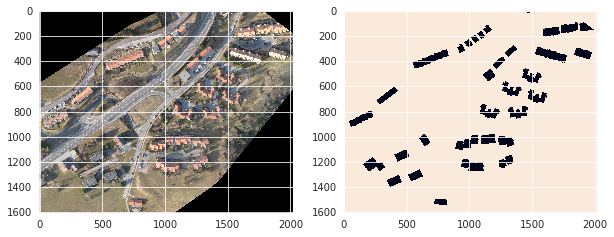

In [ ]:
data = []

img1 = Image.open(file_path[0]).convert('L')
img2 = Image.open(file_path[1]).convert('RGB')

train = np.array(img2)
label = np.array(img1)

data.append(label)
data.append(train)

fig, (ax1,ax2) = plt.subplots( ncols=2, figsize=(10, 6))
ax1.imshow(train)
ax2.imshow(label)

# pre-processing & helper function

In [ ]:
class helper():

  @staticmethod
  def batcher(iterable,label, batch_size):
    l = len(iterable)
    for batch in range(0, l, batch_size):
        yield (iterable[batch:min(batch + batch_size, l)],label[batch:min(batch + batch_size, l)])

  @staticmethod
  def shuffler(xs,ys):
    train_list = []
    label_list = []
    pairs = [(x,y) for x,y in zip(xs,ys)]
    random.shuffle(pairs)
    for pair in pairs:
      train_list.append(pair[0])
      label_list.append(pair[1])
    return(train_list,label_list)

  @staticmethod
  def Loss_opt(thenet, learning_rate):
    #Loss function / Criterion
    Lossfunc = torch.nn.CrossEntropyLoss().to(device)
      
    #Optimizer
    optimizer = optim.Adam(thenet.parameters(), lr=learning_rate)
    return(Lossfunc, optimizer)

  @staticmethod
  def prediction(model,x,y):
    m = model.cpu()
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()
    img_list = []
    for i in range(x.size(0)):
      local_output = model(x[i,:,:,:]).view(2,-1).T
      pred = (local_output[:,0] <= local_output[:,1]).long().view(256,256)
      img_list.append(pred.numpy())
    return img_list
    
  @staticmethod
  def list2img(img_list):
    img=np.array([])
    width = 8
    height = 7
    row = []
    for i in range(0,len(img_list),height+1):
      for j in range(width):
        if j == 0:
          img = img_list[i+j]
        else:
          img = np.concatenate([img,img_list[i+j]],axis=1)
      row.append(img)

    full_img =np.array([])
    for i in range(height):
      if i == 0:
        full_img = row[i]
      else:
        full_img = np.concatenate([full_img,row[i]],axis=0)
    return(full_img)

In [ ]:
class pre_processing():
  # such that each element in train_list, label_list = 256 * 256 * 3
  @staticmethod
  def chunk_img2list(img_list): 
    width = img_list[0].shape[1]
    height = img_list[0].shape[0]
    train = img_list[1]
    label = img_list[0]
    train_list = []
    label_list = []

    # padding the data
    width_pad = np.ones((height,256*math.ceil(width/256)- \
                        width,3)) * 255                    
    height_pad = np.ones((256*math.ceil(height/256)-height,256*math.ceil(width/256),3))  * 255 
                          
    label_width_pad = np.ones((height,256*math.ceil(width/256)- \
                        width)) * 255                    
    label_height_pad = np.ones((256*math.ceil(height/256)-height,256*math.ceil(width/256)))  * 255 

    train = np.concatenate([np.concatenate([train,width_pad],axis=1),
                                    height_pad],axis=0)
    label = np.concatenate([np.concatenate([label,label_width_pad],axis=1),
                                    label_height_pad],axis=0)

    
    for h in range(0,train.shape[0],256):
      for w in range(0,train.shape[1],256):
        sub_train = train[h:h+256,w:w+256,:]
        sub_label = label[h:h+256,w:w+256]
        train_list.append(sub_train)
        label_list.append(sub_label)
    return(train_list,label_list)
  
  @staticmethod
  def scaler(x,y): # such that between 0~1
    for i in range(len(x)):
      if i == 0:
        scale_train = x[i].reshape(1,256,256,3)/255
        scale_label = y[i].reshape(1,256,256)/255
      else:
        scale_train = np.concatenate([scale_train,x[i].reshape(1,256,256,3)/255],axis=0)
        scale_label = np.concatenate([scale_label,y[i].reshape(1,256,256)/255],axis=0)

    return(scale_train,scale_label)

we have 56 train images
we have 56 label images

let's see some examples:



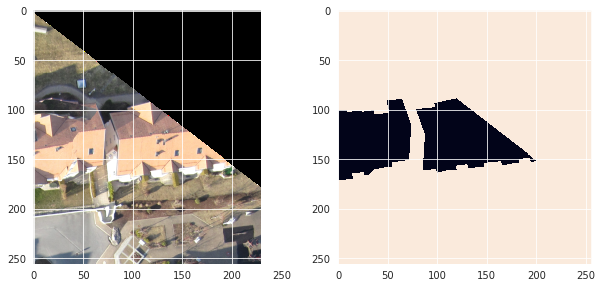

In [ ]:
x,y = pre_processing.chunk_img2list(data)
x,y = pre_processing.scaler(x,y)

print('we have {} train images'.format(len(x)))
print('we have {} label images'.format(len(y)))

# our point is to overfit the graph, so there is no need to split
#X_train, X_val, y_train, y_val = sk_ModelSelection.train_test_split(x, y, test_size=0) 

print('')
print('let\'s see some examples:')
print('')
fig, (ax1,ax2) = plt.subplots( ncols=2, figsize=(10, 6))
ax1.imshow(x[7])
ax2.imshow(y[7])

# model & training

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3,
                           out_channels = 16, 
                           kernel_size = 3,
                           stride = 1,
                           padding= 1)

    self.conv2 = nn.Conv2d(in_channels=16,
                        out_channels = 32,
                        kernel_size = 3,
                        stride = 1,
                        padding= 1)
    
    self.pooling1 = nn.MaxPool2d(kernel_size=2)

    self.conv3 = nn.Conv2d(in_channels=32,
                        out_channels = 16,
                        kernel_size = 3,
                        stride = 1,
                        padding= 1)
    
    self.upsample = nn.Upsample(scale_factor=2)
    
    self.conv4 = nn.Conv2d(in_channels=16,
                        out_channels = 2,
                        kernel_size = 5,
                        stride = 1,
                        padding= 2)
  def forward(self,x):
    x = x.view(1,3,256,256)
    x = F.relu(self.conv1(x)) 
    x = F.relu(self.conv2(x))
    x = self.pooling1(x)
    x = F.relu(self.conv3(x))
    x = self.upsample(x)
    x = self.conv4(x)
    return(x.view(2,256,256))

In [ ]:
def over_trainfunc(hyperpraram,X_train,y_train,thenet):

  # instantiate loss and opt
  (loss_function,optimizer) =helper.Loss_opt(thenet,learning_rate=hyperparam['leanring_rate'])

  #collect statistics
  train_loss =[]
  val_loss =[]
  val_acc =[]
  best_loss = 100

  #shuffle data & get batch
  X_train, y_train = helper.shuffler(X_train,y_train)

  for epoch in range(hyperpraram['max_epochs']):
    trainloss = 0

    for local_batch, local_labels in helper.batcher(X_train,y_train,hyperpraram['batch_size']):

      local_batch, local_labels = torch.Tensor(local_batch).float().to(device), \
                                  torch.Tensor(local_labels).long().to(device)

      optimizer.zero_grad()
      local_output = thenet(local_batch).view(2,-1).T
      local_labels = local_labels.view(-1)

      loss = loss_function(local_output, local_labels)   
      loss.backward()
      optimizer.step()
      trainloss += loss.item() # accumulate loss for one epoch

    train_loss.append(trainloss)

    if trainloss <= best_loss: #judge by best acc
      best_model = copy.deepcopy(thenet)
      best_loss = trainloss

      print("epoch {},loss {:.2f}".format(epoch+1,trainloss))

      # we want to overfit to learn the representation
#     validation
#     valloss = 0
#     acc = 0
#     with torch.no_grad(): # temp freeze gradient
#       for local_batch, local_labels in helper.batcher(X_val,y_val,hyperpraram['batch_size']):
#           local_batch, local_labels = torch.Tensor(local_batch).float().to(device), \
#                                       torch.Tensor(local_labels).long().to(device)

#           # compute loss & acc
#           local_output = thenet(local_batch)
#           local_output = local_output.view(2,-1).T
#           local_labels = local_labels.view(-1)
#           pred = (local_output[:,0] <= local_output[:,1]).long()
#           acc += (pred == local_labels).long().sum()

#           valloss = loss_function(local_output, local_labels)
#           valloss += valloss.item()

  return(train_loss,best_model)

In [ ]:
hyperparam= {'max_epochs':512,
               'batch_size':1,
               'leanring_rate':1e-3}

cnn = CNN().to(device)

In [ ]:
%%time
# train_loss, val_loss, acc,model = trainfunc(hyperparam,x,y,cnn)
loss,m = over_trainfunc(hyperparam,x,y,cnn)

epoch 1,loss 18.58
epoch 2,loss 13.61
epoch 3,loss 13.37
epoch 4,loss 13.06
epoch 5,loss 12.94
epoch 6,loss 12.91
epoch 7,loss 12.72
epoch 9,loss 12.56
epoch 10,loss 12.54
epoch 11,loss 12.41
epoch 12,loss 12.34
epoch 13,loss 12.28
epoch 14,loss 12.25
epoch 16,loss 12.17
epoch 17,loss 12.11
epoch 19,loss 12.06
epoch 20,loss 11.96
epoch 21,loss 11.96
epoch 22,loss 11.89
epoch 25,loss 11.77
epoch 26,loss 11.70
epoch 30,loss 11.68
epoch 31,loss 11.58
epoch 32,loss 11.52
epoch 34,loss 11.49
epoch 35,loss 11.45
epoch 36,loss 11.41
epoch 37,loss 11.36
epoch 38,loss 11.34
epoch 39,loss 11.30
epoch 40,loss 11.27
epoch 44,loss 11.26
epoch 45,loss 11.25
epoch 46,loss 11.21
epoch 47,loss 11.18
epoch 48,loss 11.15
epoch 49,loss 11.12
epoch 50,loss 11.08
epoch 52,loss 11.03
epoch 54,loss 10.95
epoch 59,loss 10.94
epoch 60,loss 10.88
epoch 64,loss 10.84
epoch 67,loss 10.81
epoch 69,loss 10.78
epoch 74,loss 10.75
epoch 77,loss 10.74
epoch 78,loss 10.60
epoch 82,loss 10.57
epoch 83,loss 10.46
epoch 84

# plot loss and accuracy

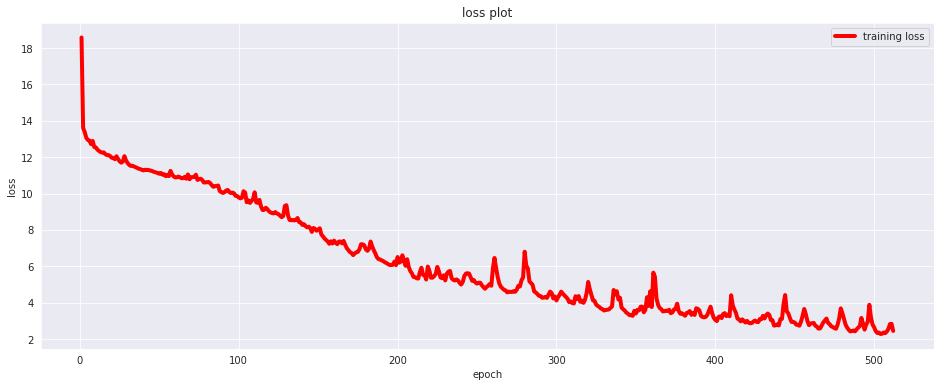

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))


ax1.plot([e for e in range(1,hyperparam['max_epochs']+1)],loss, color = 'red',linewidth=4,label='training loss')

ax1.set_ylabel('loss',fontsize=10)
ax1.set_xlabel('epoch',fontsize=10)
ax1.set_title('loss plot',fontsize=12)
ax1.legend(prop={'size':10})


# prediction


Text(0.5, 1.0, 'true')

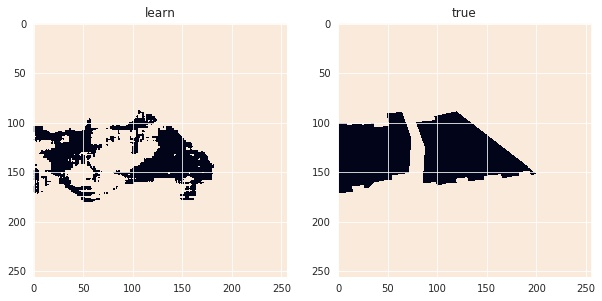

In [ ]:
img_list = helper.prediction(m,x,y) 
len(img_list)
fig, (ax1,ax2) = plt.subplots( ncols=2, figsize=(10, 6))
ax1.imshow(img_list[7])
ax1.set_title('learn')
ax2.imshow(y[7])
ax2.set_title('true')

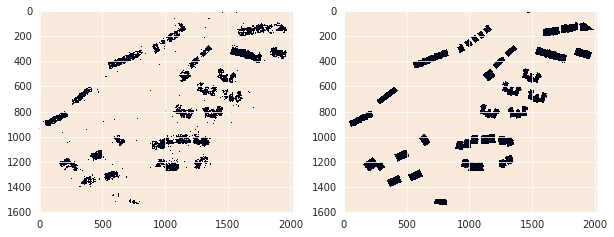

In [ ]:
img = helper.list2img(img_list)
fig, (ax1,ax2) = plt.subplots( ncols=2, figsize=(10, 6))
ax1.imshow(img[:data[0].shape[0],:data[0].shape[1]])
ax2.imshow(data[0])

Text(0.5, 1.0, 'learned image')

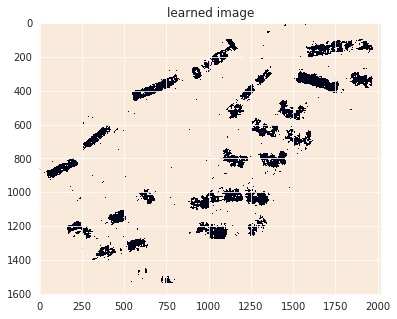

In [ ]:
fig, (ax1) = plt.subplots( ncols=1, figsize=(8, 5))
ax1.imshow(img[:data[0].shape[0],:data[0].shape[1]])
ax1.set_title('learned image')